In [483]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [484]:
DATA_DIR = Path('../../data')
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
OUTPUT_SL_DIR = Path('../../output/images/Supervised/')

In [485]:
def make_conf_matrix(labels_test, predictions, algo_name):
    conf_matrix: np.ndarray = confusion_matrix(labels_test, predictions)
    fig = plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="g")
    plt.title(f"Confusion Matrix: {algo_name}")
    plt.ylabel('Actual label (0: bot, 1: human)')
    plt.xlabel('Predicted label (0: bot, 1: human)')
    fig.savefig(OUTPUT_SL_DIR / f"confusion_matrix_{algo_name.lower().replace(' ', '_')}.png")
    plt.show()

In [486]:
df_train: pd.DataFrame = pd.read_csv(PROCESSED_DATA_DIR / 'train.csv')
df_test: pd.DataFrame = pd.read_csv(PROCESSED_DATA_DIR / 'test.csv')

df_features_train = df_train.drop('account_type', axis=1)
df_features_test = df_test.drop('account_type', axis=1)
labels_train: pd.core.series.Series = df_train['account_type']  # NOTE: Label bot = 0; label human = 1.
labels_test: pd.core.series.Series = df_test['account_type']

# Supervised Learning: Decision Tree

In [487]:
dt_classifier = DecisionTreeClassifier(
    max_depth=30,
    min_samples_split=10,
)
dt_classifier.fit(df_features_train, labels_train)
dt_predictions: np.ndarray = dt_classifier.predict(df_features_test)
dt_accuracy: np.float64 = classification_report(labels_test, dt_predictions)
print(dt_accuracy)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       150
           1       1.00      0.97      0.98       749

    accuracy                           0.97       899
   macro avg       0.93      0.97      0.95       899
weighted avg       0.97      0.97      0.97       899



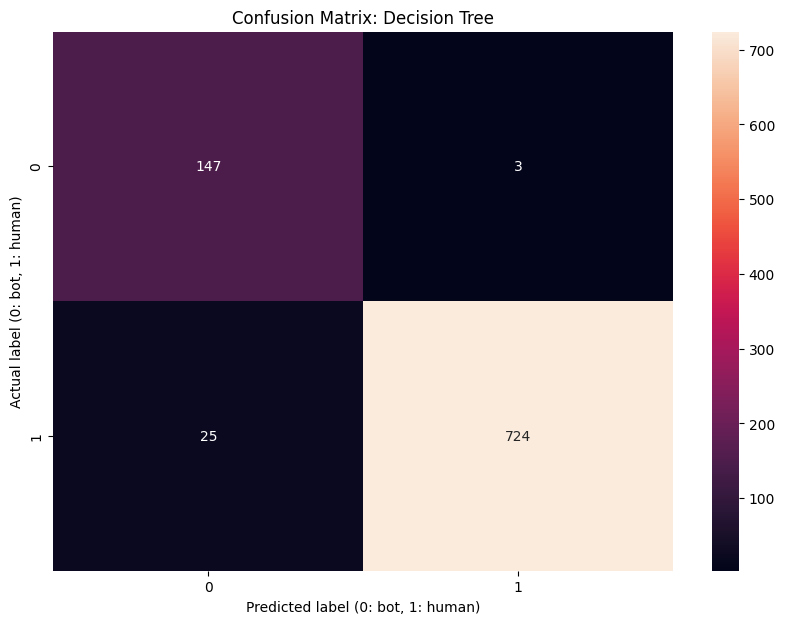

In [488]:
make_conf_matrix(labels_test=labels_test, predictions=dt_predictions, algo_name="Decision Tree")

# Supervised Learning: SVM

In [489]:
scaler = StandardScaler()
df_features_train_scaled: np.ndarray = scaler.fit_transform(df_features_train)
df_features_test_scaled: np.ndarray = scaler.transform(df_features_test)

svm_classifier = SVC(
    kernel='rbf',
    probability=True,
)
svm_classifier.fit(df_features_train_scaled, labels_train)
svm_predictions: np.ndarray = svm_classifier.predict(df_features_test_scaled)
svm_accuracy: str = classification_report(labels_test, svm_predictions)
print(svm_accuracy)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       150
           1       0.99      0.97      0.98       749

    accuracy                           0.97       899
   macro avg       0.93      0.97      0.95       899
weighted avg       0.97      0.97      0.97       899



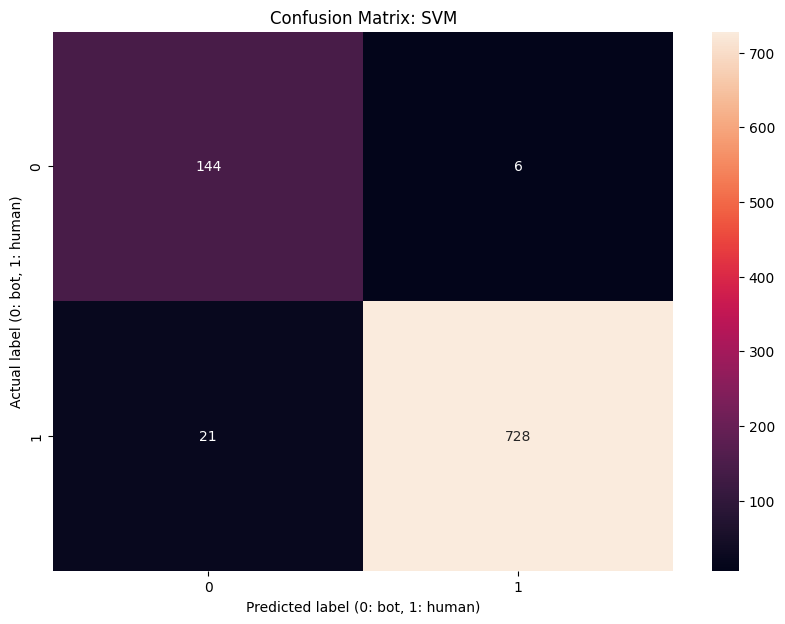

In [490]:
make_conf_matrix(labels_test=labels_test, predictions=svm_predictions, algo_name="SVM")

# Supervised Learning: Random Forrest

In [491]:
rf_classifier = RandomForestClassifier()

rf_classifier.fit(df_features_train, labels_train)
rf_predictions: np.ndarray = rf_classifier.predict(df_features_test)
rf_accuracy: str = classification_report(labels_test, rf_predictions)
print(rf_accuracy)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       150
           1       1.00      0.99      0.99       749

    accuracy                           0.99       899
   macro avg       0.98      0.99      0.98       899
weighted avg       0.99      0.99      0.99       899



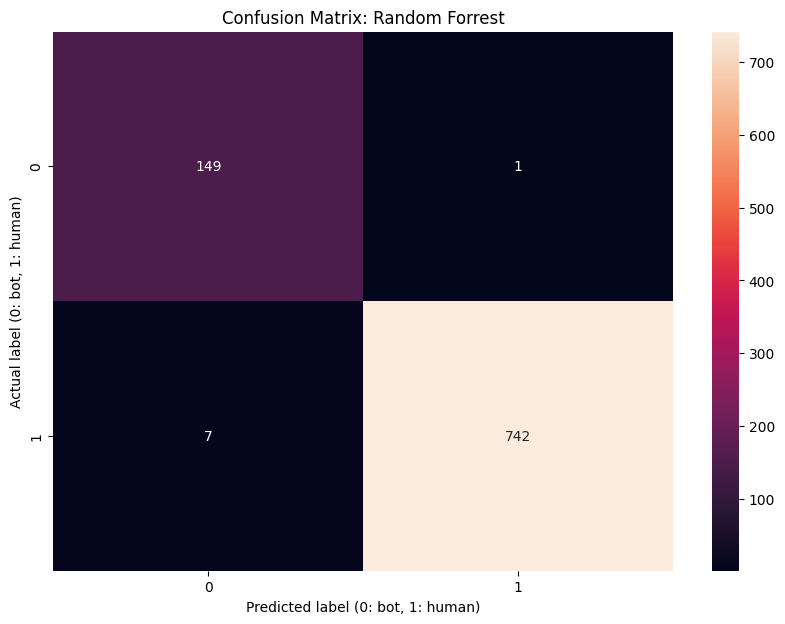

In [492]:
make_conf_matrix(labels_test=labels_test, predictions=rf_predictions, algo_name="Random Forrest")

# Receiver Operating Characteristic Curve - All

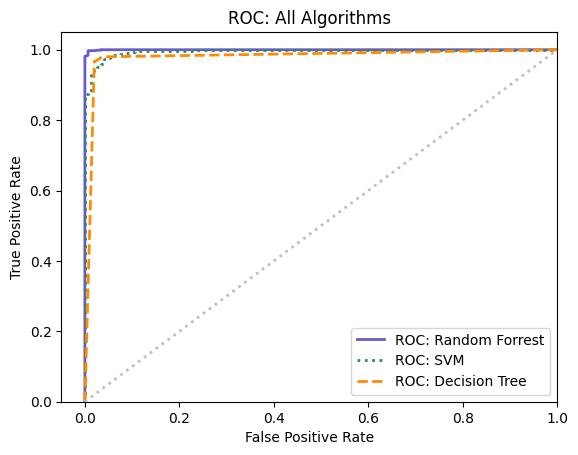

In [493]:
rf_fpr: np.ndarray
rf_tpr: np.ndarray
svm_fpr: np.ndarray
svm_tpr: np.ndarray
dt_fpr: np.ndarray
dt_tpr: np.ndarray

rf_fpr, rf_tpr, _ = roc_curve(labels_test, rf_classifier.predict_proba(df_features_test)[:, 1])
svm_fpr, svm_tpr, _ = roc_curve(labels_test, svm_classifier.predict_proba(df_features_test_scaled)[:, 1])
dt_fpr, dt_tpr, _ = roc_curve(labels_test, dt_classifier.predict_proba(df_features_test)[:, 1])

fig = plt.figure()
plt.plot(rf_fpr, rf_tpr, color='slateblue', lw=2, linestyle='-', label='ROC: Random Forrest')
plt.plot(svm_fpr, svm_tpr, color='seagreen', lw=2, linestyle=':', label='ROC: SVM')
plt.plot(dt_fpr, dt_tpr, color='darkorange', lw=2, linestyle='--', label='ROC: Decision Tree')
plt.plot([0, 1], [0, 1], color='silver', lw=2, linestyle=':')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: All Algorithms')
plt.legend(loc="lower right")
fig.savefig(OUTPUT_SL_DIR / f"roc_all.png")
plt.show()

# Example with GridSearchCV for parameter tuning

Note: It delivers a worse result than our brute-force approach

In [494]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(10, 101, 10)),
    'min_samples_split': [2, 5, 10],
    'min_impurity_decrease': [0.0, 0.01, 0.02, 0.05],
    'splitter': ['best', 'random'],
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, verbose=0, n_jobs=-1)
grid_search.fit(df_features_train, labels_train)
print(f"Best parameters: {grid_search.best_params_}")

best_dt_classifier: DecisionTreeClassifier = grid_search.best_estimator_
dt_predictions: np.ndarray = best_dt_classifier.predict(df_features_test)
dt_accuracy: str = classification_report(labels_test, dt_predictions)
print(dt_accuracy)

Best parameters: {'criterion': 'gini', 'max_depth': 50, 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       150
           1       1.00      0.98      0.99       749

    accuracy                           0.98       899
   macro avg       0.95      0.98      0.96       899
weighted avg       0.98      0.98      0.98       899

